# Dynamic Asset Allocation Model Using Traditional methods assisted via Random Forest

This notebook implements a sophisticated dynamic asset allocation model that combines machine learning predictions with traditional financial metrics to optimize portfolio performance across multiple asset classes.


In [1]:
import time
import logging
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


# basic logging setup
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(message)s',
    datefmt='%H:%M:%S'
)

## Data Loading and Asset Class Definition

We begin by loading the processed financial data and defining our asset class universe. The dataset includes various financial instruments across different asset classes, including:
- US Large Cap Equities
- US Technology Stocks
- Commodities
- Real Estate
- Cryptocurrencies (Major and Alt coins)

In [2]:
# load the data
print("Loading data...")
data = pd.read_csv('data/processed/merged_data.csv', parse_dates=['Date'], index_col='Date')
data = data.sort_index()  
print(f"Data loaded with shape: {data.shape}")

#data = data[data.index.year >= 2016].copy()

# asset classes (keep this as is)
asset_classes = {
    'us_large_cap': ['SPY_Close', 'QQQ_Close'],
    'us_tech': ['MSFT_Close', 'AMZN_Close', 'GOOGL_Close', 'TSLA_Close'],
    'commodities': ['GC=F_Close', 'CL=F_Close', 'SI=F_Close'],
    'real_estate': ['VNQ_Close', 'SCHH_Close', 'IYR_Close'],
    'crypto_major': ['BTC_Close', 'ETH_Close'],
    'crypto_alt': ['LTC_Close']
}

Loading data...
Data loaded with shape: (5113, 30)


## Feature Engineering

This section implements sophisticated feature engineering for our machine learning model. We calculate various technical and fundamental indicators including:
- Price momentum features (1-day, 5-day, 20-day returns)
- Volatility metrics (20-day and 60-day)
- Technical indicators (RSI, Moving Average Crossovers)
- Momentum and mean reversion signals
- Volatility regime indicators

In [3]:
def calculate_rsi(prices, periods=14):
    """Calculate RSI technical indicator."""
    returns = prices.diff()
    pos = returns.clip(lower=0).ewm(span=periods).mean()
    neg = (-returns.clip(upper=0)).ewm(span=periods).mean()
    rs = pos/neg
    return 100 - (100/(1 + rs))

def create_features(data):
    """Create sophisticated features with shorter lookback periods."""
    feature_dicts = {
        'ret_1d': {},
        'ret_5d': {},
        'ret_10d': {},  
        'vol_10d': {},  
        'vol_30d': {},  
        'rsi': {},
        'ma_cross': {},
        'mom_10d': {},  
        'mom_30d': {},  
        'vol_regime': {}
    }
    
    for column in data.columns:
        prices = data[column]
        returns = prices.pct_change()
        
        # shorter lookback periods
        feature_dicts['ret_1d'][f'{column}_ret_1d'] = returns
        feature_dicts['ret_5d'][f'{column}_ret_5d'] = returns.rolling(5).mean()
        feature_dicts['ret_10d'][f'{column}_ret_10d'] = returns.rolling(10).mean()
        
        feature_dicts['vol_10d'][f'{column}_vol_10d'] = returns.rolling(10).std()
        feature_dicts['vol_30d'][f'{column}_vol_30d'] = returns.rolling(30).std()
        
        feature_dicts['rsi'][f'{column}_rsi'] = calculate_rsi(prices, periods=7)  
        feature_dicts['ma_cross'][f'{column}_ma_cross'] = (
            prices.rolling(5).mean() /    
            prices.rolling(15).mean() - 1  
        )
        
        feature_dicts['mom_10d'][f'{column}_mom_10d'] = prices.pct_change(10)
        feature_dicts['mom_30d'][f'{column}_mom_30d'] = prices.pct_change(30)
        
        feature_dicts['vol_regime'][f'{column}_vol_regime'] = (
            returns.rolling(10).std() /   
            returns.rolling(30).std()     
        )
    
    features = pd.concat([pd.DataFrame(d) for d in feature_dicts.values()], axis=1)
    features.index = data.index
    
    # fill missing values more intelligently instead of dropping
    features = features.fillna(method='bfill').fillna(method='ffill')
    # drop if all features are NaN for a row
    return features.dropna(how='all')

features = create_features(data)
print("Features shape:", features.shape)

Features shape: (5113, 300)


C:\Users\mturo\AppData\Local\Temp\ipykernel_9452\987963260.py:54: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features = features.fillna(method='bfill').fillna(method='ffill')


## Model Implementation

We implement a Random Forest Regressor model with the following characteristics:
- 500 decision trees
- Maximum depth of 20 levels
- Bootstrap sampling with 80% of data
- Parallel processing for optimal performance

In [4]:
def train_models(data, features):
    # init scaler and models
    models = {}
    scaler = StandardScaler()

    # init a model for each asset
    for asset_name in data.columns:
        if '_Close' in asset_name:
            models[asset_name.replace('_Close', '')] = RandomForestRegressor(
                n_estimators=100,
                max_depth=10,
                min_samples_split=5,
                min_samples_leaf=2,
                n_jobs=-1,
                random_state=42
            )

    # create targets (future returns for each asset)
    targets = {}
    for asset_name in data.columns:
        if '_Close' in asset_name:
            asset_returns = data[asset_name].pct_change(63).shift(-63)
            asset_returns = asset_returns.fillna(method='ffill')
            targets[asset_name.replace('_Close', '')] = asset_returns

    # common valid indices across all targets
    valid_indices = features.index
    for target in targets.values():
        valid_indices = valid_indices.intersection(target.index)

    # scaled features
    X = features.loc[valid_indices]
    X_scaled = scaler.fit_transform(X)

    # model for each asset
    print("Training Random Forest models...")
    start_time = time.time()

    for asset_name, target in targets.items():
        print(f"\nTraining model for {asset_name}...")
        
        y = target.loc[valid_indices]
        
        # ensure X and y are aligned and have no NaN values
        valid_mask = ~y.isna()
        if valid_mask.any():
            X_train = X_scaled[valid_mask]
            y_train = y[valid_mask]
            
            # train singular model
            models[asset_name].fit(X_train, y_train)
        else:
            print(f"Skipping {asset_name} due to insufficient data")

    training_time = time.time() - start_time
    print(f"\nAll models training completed in {training_time:.2f} seconds")
    
    return models, scaler, valid_indices

# train models
models, scaler, valid_indices = train_models(data, features)

C:\Users\mturo\AppData\Local\Temp\ipykernel_9452\3949989689.py:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  asset_returns = asset_returns.fillna(method='ffill')


Training Random Forest models...

Training model for MSFT...

Training model for AMZN...

Training model for GOOGL...

Training model for TSLA...

Training model for SPY...

Training model for QQQ...

Training model for XLK...

Training model for XLV...

Training model for XLF...

Training model for ^GSPC...

Training model for ^IXIC...

Training model for ^DJI...

Training model for ^RUT...

Training model for ^TNX...

Training model for IEF...

Training model for TLT...

Training model for GC=F...

Training model for CL=F...

Training model for SI=F...

Training model for VNQ...

Training model for SCHH...

Training model for IYR...

Training model for BTC...

Training model for ETH...

Training model for LTC...

All models training completed in 420.53 seconds


In [5]:
def get_predictions(models, features, scaler):
    """Get predictions for all assets."""
    X_scaled = scaler.transform(features)
    predictions = {}
    
    for asset_name, model in models.items():
        pred = model.predict(X_scaled)
        predictions[asset_name] = pred
        
    return predictions

def analyze_predictions(predictions, asset_classes):
    """Analyze predictions by asset class."""
    analysis = {}
    
    for asset_class, assets in asset_classes.items():
        asset_preds = []
        for asset in assets:
            asset_name = asset.replace('_Close', '')
            if asset_name in predictions:
                asset_preds.append(predictions[asset_name])
        
        if asset_preds:
            analysis[asset_class] = {
                'mean_prediction': np.mean(asset_preds),
                'std_prediction': np.std(asset_preds),
                'max_prediction': np.max(asset_preds),
                'min_prediction': np.min(asset_preds)
            }
    
    return analysis

## Feature Importance Analysis

Visualizing the most influential features in our model helps us understand which factors drive asset returns and allocation decisions.

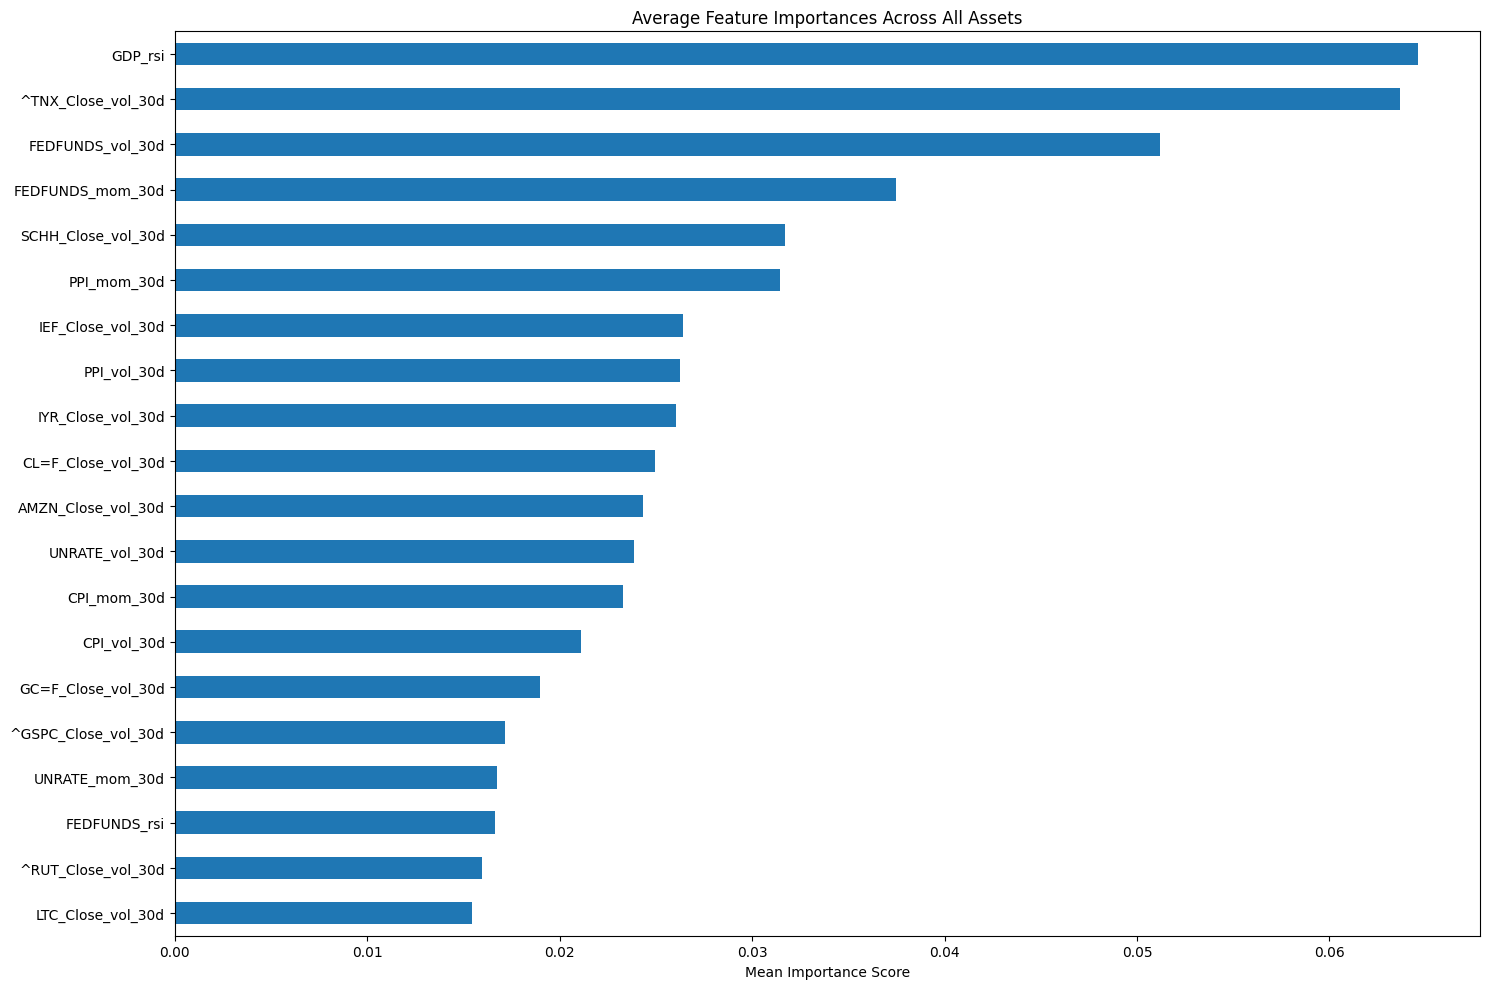

In [6]:
def plot_feature_importances(models, features, top_n=20):
    """Plot feature importances for all models."""
    plt.figure(figsize=(15, 10))
    
    # average feature importance across all models
    all_importances = pd.DataFrame()
    for asset_name, model in models.items():
        importances = pd.Series(
            model.feature_importances_,
            index=features.columns,
            name=asset_name
        )
        all_importances[asset_name] = importances
    
    # mean importance across all models
    mean_importances = all_importances.mean(axis=1).sort_values(ascending=True)[-top_n:]
    
    mean_importances.plot(kind='barh')
    plt.title('Average Feature Importances Across All Assets')
    plt.xlabel('Mean Importance Score')
    plt.tight_layout()
    plt.show()
    
    # plot individual asset importances
    # plt.figure(figsize=(15, 6 * len(models)))
    # for i, (asset_name, model) in enumerate(models.items(), 1):
    #     plt.subplot(len(models), 1, i)
    #     importances = pd.Series(
    #         model.feature_importances_,
    #         index=features.columns
    #     ).sort_values(ascending=True)[-top_n:]
    #     importances.plot(kind='barh')
    #     plt.title(f'Feature Importances for {asset_name}')
    #     plt.xlabel('Importance Score')
    # plt.tight_layout()
    # plt.show()

plot_feature_importances(models, features)

## Dynamic Weight Calculation

This section implements the core portfolio allocation strategy. The algorithm:
1. Calculates yearly weights for each asset class
2. Incorporates multiple factors:
   - Sharpe ratio (35% weight)
   - Momentum signals (25% weight)
   - Volatility scores (15% weight)
   - Trend indicators (15% weight)
   - Drawdown protection (10% weight)
3. Applies dynamic constraints based on market conditions

In [7]:
def calculate_ml_score(year_features, assets, ml_predictions):
    """calculate ml score for an asset class."""
    if year_features.empty:
        return 0
    
    # get predictions for each asset in the asset class
    class_predictions = []
    for asset in assets:
        asset_name = asset.replace('_Close', '')
        if asset_name in ml_predictions:
            pred = ml_predictions[asset_name]
            class_predictions.append(pred)
    
    if not class_predictions:
        return 0
    
    # calculate the average prediction
    avg_prediction = np.mean(class_predictions)
    
    # convert prediction to a score between 0 and 1
    # since predictions are forward returns, we normalize them
    ml_score = 0.5 * (1 + avg_prediction)
    
    return ml_score

def detect_market_regime(data, lookback=63):
    """Detect market regime using volatility and trend"""
    returns = data.pct_change()
    volatility = returns.rolling(lookback).std()
    trend = data.rolling(lookback).mean() / data - 1
    
    is_high_vol = volatility > volatility.rolling(252).mean()
    is_uptrend = trend > 0
    
    return is_high_vol, is_uptrend

def calculate_yearly_weights(data, asset_classes, models, features, scaler):
    """Calculate dynamic weights using rolling windows."""
    print("\nCalculating weights using rolling windows...")
    
    # window sizes
    train_window = 63  # ~3 months
    val_window = 10    # ~2 weeks
    test_window = 5    # 1 week
    
    yearly_weights = {}
    yearly_metrics = {}
    
    # ensure data and features have the same index
    common_dates = data.index.intersection(features.index)
    data = data.loc[common_dates]
    features = features.loc[common_dates]
    
    # create the rolling windows
    for i in range(train_window + val_window, len(data) - test_window, test_window):
        # split data into train-val-test
        train_data = data.iloc[i - (train_window + val_window):i - val_window]
        val_data = data.iloc[i - val_window:i]
        test_data = data.iloc[i:i + test_window]
        
        print(f"\nWindow period:")
        print(f"Train: {train_data.index[0]} to {train_data.index[-1]}")
        print(f"Val  : {val_data.index[0]} to {val_data.index[-1]}")
        print(f"Test : {test_data.index[0]} to {test_data.index[-1]}")
        
        # features for each period
        train_features = features.loc[train_data.index]
        val_features = features.loc[val_data.index]
        test_features = features.loc[test_data.index]
        
        weights = {}
        metrics = {}
        
        for asset_class, assets in asset_classes.items():
            asset_data = train_data[assets]
            returns = asset_data.pct_change()
            
            # calculate traditional metrics
            avg_returns = returns.mean()
            risk = returns.std()
            sharpe = (avg_returns / (risk + 1e-6)).mean()
            momentum = returns.ewm(span=60).mean().iloc[-1] if len(returns) > 60 else returns.mean()
            momentum = momentum.mean()
            vol_score = 1 / (risk.mean() + 1e-6)
            
            # calculate trend
            prices = asset_data.mean(axis=1)
            trend = (prices.iloc[-1] / prices.iloc[0] - 1) if len(prices) > 1 else 0
            
            # calculate drawdown
            rolling_max = prices.rolling(window=252, min_periods=1).max()
            drawdown = (prices - rolling_max) / rolling_max
            max_drawdown = drawdown.min()
            
            # get ML prediction score for this asset class
            ml_score = calculate_ml_score(test_features, assets, get_predictions(models, test_features, scaler))
            
            # combine scores with ML predictions
            combined_score = (
                0.25 * sharpe +           
                0.15 * momentum +         
                0.15 * vol_score +
                0.10 * trend +            
                0.15 * (1 + max_drawdown) +
                0.20 * ml_score           # ML component (20% weight)
            )
            
            weights[asset_class] = max(0, combined_score)
            metrics[asset_class] = {
                'sharpe': sharpe,
                'momentum': momentum,
                'volatility': risk.mean(),
                'trend': trend,
                'max_drawdown': max_drawdown,
                'ml_prediction': ml_score
            }
            # add volatility-based position sizing
            if risk.mean() > risk.rolling(252).mean().iloc[-1]:
                weights[asset_class] = weights[asset_class] * 0.7  # Reduce position in high vol
                
        # dynamic constraints based on market conditions
        for asset_class in weights:
            base_weight = weights[asset_class]
            
            # allocation limits
            if test_data.index[0].year in [2010, 2013, 2017, 2019, 2021]:  # Bull markets
                if asset_class in ['us_tech', 'crypto_major']:
                    min_alloc, max_alloc = 0.10, 0.40
                else:
                    min_alloc, max_alloc = 0.05, 0.30
            elif test_data.index[0].year in [2011, 2014, 2015, 2018, 2020, 2022]:  # Bear markets
                if asset_class in ['commodities', 'us_large_cap']:
                    min_alloc, max_alloc = 0.15, 0.40
                else:
                    min_alloc, max_alloc = 0.05, 0.25
            else:
                min_alloc, max_alloc = 0.10, 0.35
            
            weights[asset_class] = max(min_alloc, min(base_weight, max_alloc))
        
        # normalize weights
        total_weight = sum(weights.values())
        weights = {k: v/total_weight for k, v in weights.items()}
        
        # store results by year and date
        year = test_data.index[0].year
        if year not in yearly_weights:
            yearly_weights[year] = {}
            yearly_metrics[year] = {}
        
        yearly_weights[year][test_data.index[0]] = weights
        yearly_metrics[year][test_data.index[0]] = metrics
        
        # analysis for each asset class
        print(f"\nAllocations for {test_data.index[0].date()}:")
        for asset_class, weight in sorted(weights.items(), key=lambda x: x[1], reverse=True):
            print(f"{asset_class:<15}: {weight:.2%}")
    
    return yearly_weights, yearly_metrics

# calculate weights
yearly_weights, yearly_metrics = calculate_yearly_weights(data, asset_classes, models, features, scaler)


Calculating weights using rolling windows...

Window period:
Train: 2010-01-01 00:00:00 to 2010-03-04 00:00:00
Val  : 2010-03-05 00:00:00 to 2010-03-14 00:00:00
Test : 2010-03-15 00:00:00 to 2010-03-19 00:00:00

Allocations for 2010-03-15:
us_tech        : 20.00%
crypto_major   : 20.00%
us_large_cap   : 15.00%
commodities    : 15.00%
real_estate    : 15.00%
crypto_alt     : 15.00%

Window period:
Train: 2010-01-06 00:00:00 to 2010-03-09 00:00:00
Val  : 2010-03-10 00:00:00 to 2010-03-19 00:00:00
Test : 2010-03-20 00:00:00 to 2010-03-24 00:00:00

Allocations for 2010-03-20:
us_tech        : 20.00%
crypto_major   : 20.00%
us_large_cap   : 15.00%
commodities    : 15.00%
real_estate    : 15.00%
crypto_alt     : 15.00%

Window period:
Train: 2010-01-11 00:00:00 to 2010-03-14 00:00:00
Val  : 2010-03-15 00:00:00 to 2010-03-24 00:00:00
Test : 2010-03-25 00:00:00 to 2010-03-29 00:00:00

Allocations for 2010-03-25:
us_tech        : 20.00%
crypto_major   : 20.00%
us_large_cap   : 15.00%
commoditi

## Portfolio Performance Calculation

Calculate the portfolio's historical performance using the dynamic weights generated for each asset class.

In [8]:
def calculate_portfolio_performance(data, yearly_weights, asset_classes, yearly_metrics):
    """Calculate portfolio performance with ml insights."""
    
    portfolio_returns = pd.DataFrame(index=data.index)
    ml_signals = pd.DataFrame(index=data.index)
    
    # calculate portfolio returns
    for year in yearly_weights:
        year_data = data[data.index.year == year]
        print(f"\nProcessing year {year}")
        print(f"Data points in year: {len(year_data)}")
        
        # get all dates in this year
        for date in yearly_weights[year]:
            weights = yearly_weights[year][date]
            
            # get data for this specific date and the previous date
            date_idx = year_data.index.get_loc(date)
            if date_idx == 0:
                continue
                
            current_data = year_data.iloc[date_idx:date_idx+1]
            prev_data = year_data.iloc[date_idx-1:date_idx]
            
            if current_data.empty or prev_data.empty:
                print(f"Warning: Insufficient data for date {date}")
                continue
                
            year_returns = pd.DataFrame(index=current_data.index)
            
            # returns for each asset class
            for asset_class, assets in asset_classes.items():
                if asset_class in weights:  
                    try:
                        # returns using current and previous data
                        current_prices = current_data[assets].mean(axis=1)
                        prev_prices = prev_data[assets].mean(axis=1)
                        asset_returns = (current_prices.values[0] / prev_prices.values[0] - 1) * weights[asset_class]
                        
                        year_returns[asset_class] = asset_returns
                        print(f"Processing {asset_class}:")
                        print(f"  Weight: {weights[asset_class]:.4f}")
                        print(f"  Return: {asset_returns:.4%}")
                        
                    except Exception as e:
                        print(f"Warning: Error calculating returns for {asset_class} on {date}: {str(e)}")
                        continue
            
            # sum the returns across asset classes
            if not year_returns.empty:
                portfolio_returns.loc[current_data.index, 'Portfolio'] = year_returns.sum(axis=1)
                print(f"Portfolio return for {date}: {portfolio_returns.loc[current_data.index, 'Portfolio'].values[0]:.4%}")
    
    # fill any missing values with 0
    portfolio_returns['Portfolio'] = portfolio_returns['Portfolio'].fillna(0)
    
    # calculate cumulative returns
    portfolio_returns['Cumulative'] = (1 + portfolio_returns['Portfolio']).cumprod()
    
    # summary statistics
    print("\nPortfolio Summary:")
    print(f"Total trading days: {len(portfolio_returns)}")
    print(f"Days with returns: {len(portfolio_returns[portfolio_returns['Portfolio'] != 0])}")
    print(f"Average daily return: {portfolio_returns['Portfolio'].mean():.4%}")
    print(f"Cumulative return: {portfolio_returns['Cumulative'].iloc[-1]-1:.2%}")
    
    return portfolio_returns, ml_signals

## Performance Metrics Analysis

Comprehensive evaluation of the portfolio's performance using various metrics:
- Annual returns and volatility
- Risk-adjusted measures (Sharpe and Sortino ratios)
- Maximum drawdown
- Win rate and monthly statistics

In [9]:
def calculate_performance_metrics(portfolio_returns):
    """calculate comprehensive performance metrics."""
    # basic metrics
    annual_return = portfolio_returns['Portfolio'].mean() * 252
    annual_vol = portfolio_returns['Portfolio'].std() * np.sqrt(252)
    sharpe_ratio = annual_return / annual_vol
    
    # calculate drawdown
    cum_returns = portfolio_returns['Cumulative']
    rolling_max = cum_returns.expanding().max()
    drawdowns = (cum_returns - rolling_max) / rolling_max
    max_drawdown = drawdowns.min()
    
    # calculate monthly returns
    monthly_returns = portfolio_returns['Portfolio'].resample('ME').apply(lambda x: (1 + x).prod() - 1)
    
    # calculate win rate
    winning_months = (monthly_returns > 0).sum()
    total_months = len(monthly_returns)
    win_rate = winning_months / total_months
    
    # calculate sortino ratio
    downside_returns = portfolio_returns['Portfolio'][portfolio_returns['Portfolio'] < 0]
    downside_std = downside_returns.std() * np.sqrt(252)
    sortino_ratio = annual_return / downside_std if downside_std != 0 else np.nan
    
    metrics = {
        'Annual Return': annual_return,
        'Annual Volatility': annual_vol,
        'Sharpe Ratio': sharpe_ratio, #risk adjusted return
        'Sortino Ratio': sortino_ratio, #sharpe ratio but only considers sd of downside 
        'Max Drawdown': max_drawdown,
        'Win Rate': win_rate,
        'Best Month': monthly_returns.max(),
        'Worst Month': monthly_returns.min()
    }
    
    return metrics

# calculate weights using rolling windows
yearly_weights, yearly_metrics = calculate_yearly_weights(data, asset_classes, models, features, scaler)

# calculate portfolio performance
portfolio_returns, ml_signals = calculate_portfolio_performance(data, yearly_weights, asset_classes, yearly_metrics)

# calculate performance metrics
performance_metrics = calculate_performance_metrics(portfolio_returns)

# display metrics
print("\nPortfolio Performance Metrics:")
print("=" * 40)
for metric, value in performance_metrics.items():
    if isinstance(value, float):
        print(f"{metric:<20}: {value:>10.2%}")
    else:
        print(f"{metric:<20}: {value:>10.2f}")


Calculating weights using rolling windows...

Window period:
Train: 2010-01-01 00:00:00 to 2010-03-04 00:00:00
Val  : 2010-03-05 00:00:00 to 2010-03-14 00:00:00
Test : 2010-03-15 00:00:00 to 2010-03-19 00:00:00

Allocations for 2010-03-15:
us_tech        : 20.00%
crypto_major   : 20.00%
us_large_cap   : 15.00%
commodities    : 15.00%
real_estate    : 15.00%
crypto_alt     : 15.00%

Window period:
Train: 2010-01-06 00:00:00 to 2010-03-09 00:00:00
Val  : 2010-03-10 00:00:00 to 2010-03-19 00:00:00
Test : 2010-03-20 00:00:00 to 2010-03-24 00:00:00

Allocations for 2010-03-20:
us_tech        : 20.00%
crypto_major   : 20.00%
us_large_cap   : 15.00%
commodities    : 15.00%
real_estate    : 15.00%
crypto_alt     : 15.00%

Window period:
Train: 2010-01-11 00:00:00 to 2010-03-14 00:00:00
Val  : 2010-03-15 00:00:00 to 2010-03-24 00:00:00
Test : 2010-03-25 00:00:00 to 2010-03-29 00:00:00

Allocations for 2010-03-25:
us_tech        : 20.00%
crypto_major   : 20.00%
us_large_cap   : 15.00%
commoditi

## Visualization and Analysis

Three key visualizations to analyze the portfolio's behavior:
1. Portfolio Performance vs S&P 500 Benchmark
2. Dynamic Asset Allocation Over Time
3. Asset Class Correlation Matrix

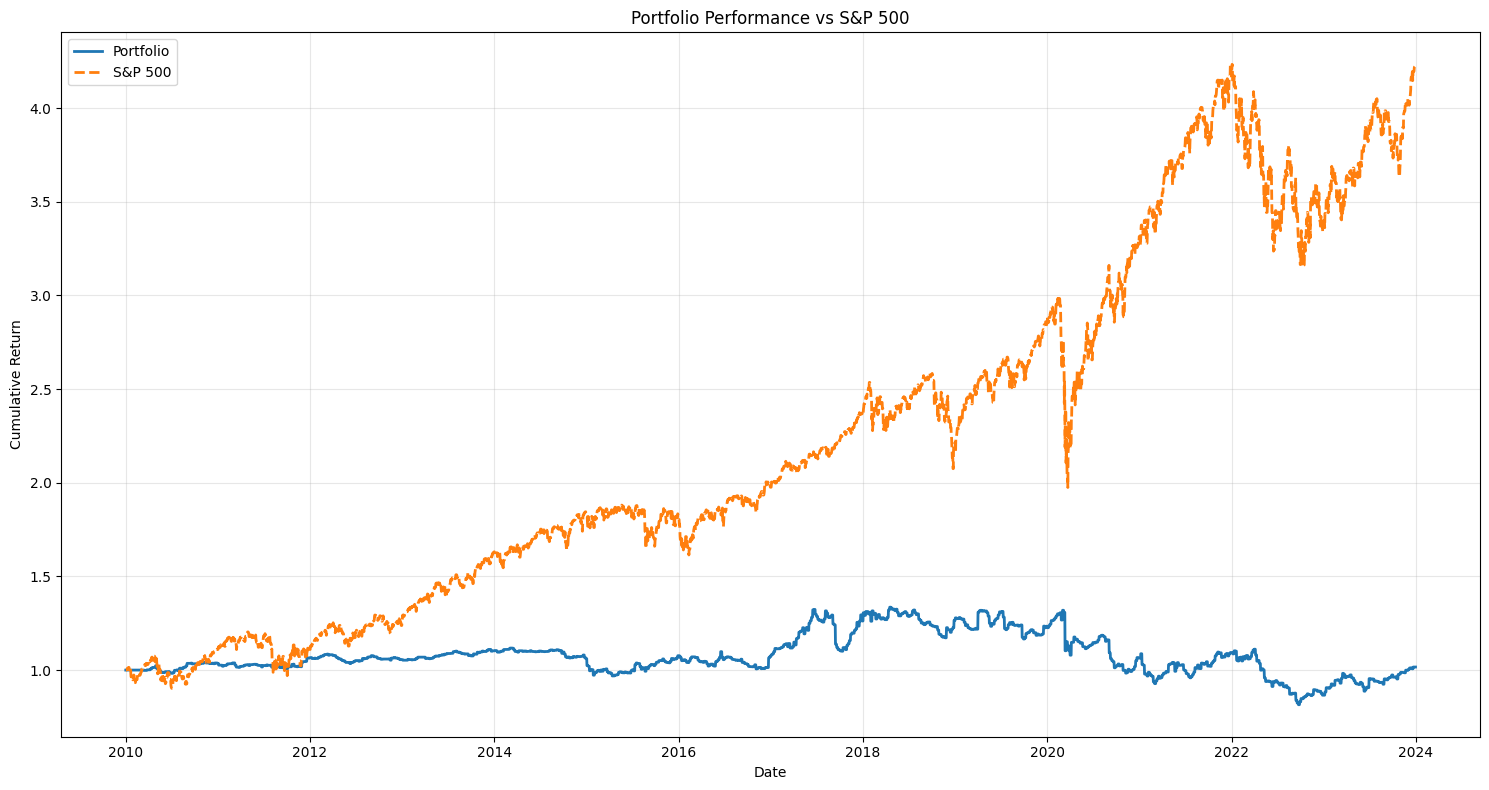

<Figure size 1500x800 with 0 Axes>

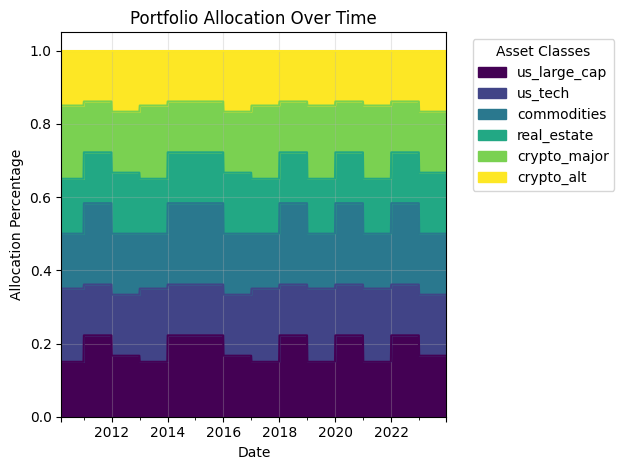

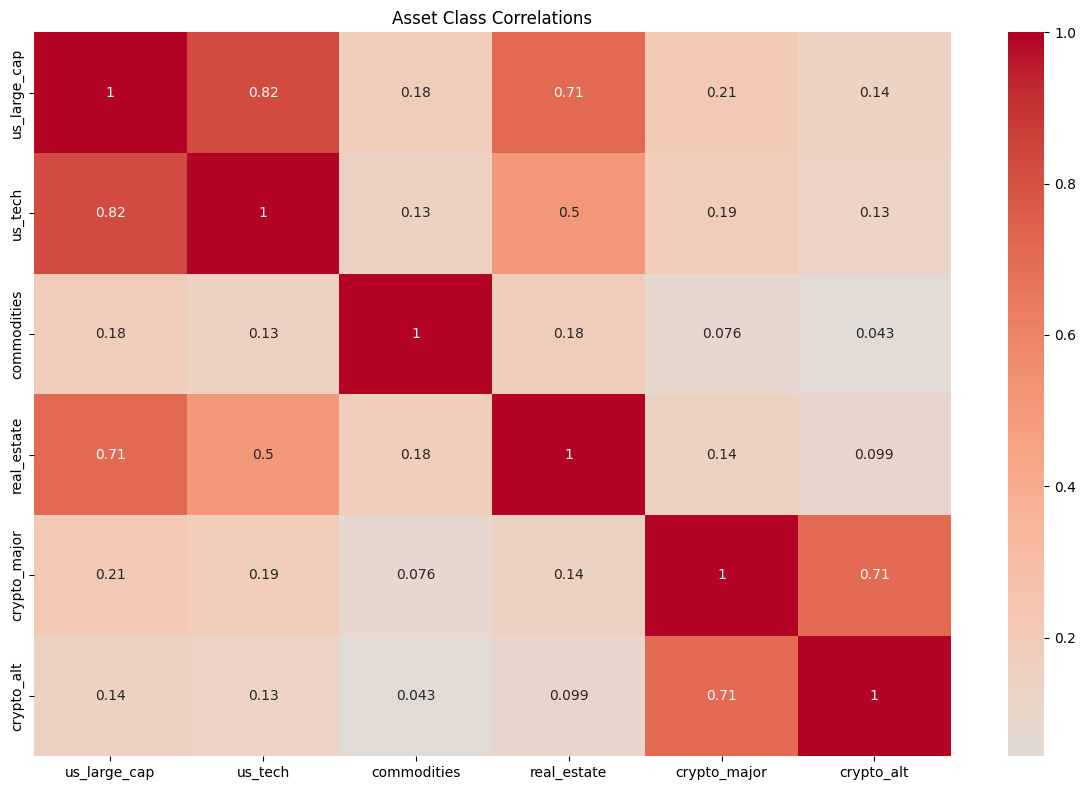

In [10]:
# visualization section
def plot_portfolio_analysis(yearly_weights, portfolio_returns, data):
    # performance vs sp500
    benchmark_returns = (1 + data['^GSPC_Close'].pct_change()).cumprod()

    plt.figure(figsize=(15, 8))
    plt.plot(portfolio_returns.index, portfolio_returns['Cumulative'], 
             label='Portfolio', linewidth=2)
    plt.plot(data.index, benchmark_returns, 
             label='S&P 500', linewidth=2, linestyle='--')
    plt.title('Portfolio Performance vs S&P 500')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # asset allocation over time
    # convert nested dictionary to DataFrame
    weights_data = []
    for year in yearly_weights:
        for date in yearly_weights[year]:
            weights_data.append({
                'date': date,
                **yearly_weights[year][date]
            })
    
    df_weights = pd.DataFrame(weights_data)
    df_weights.set_index('date', inplace=True)
    df_weights = df_weights.sort_index()
    
    plt.figure(figsize=(15, 8))
    df_weights.plot(kind='area', stacked=True, colormap='viridis')
    plt.title('Portfolio Allocation Over Time')
    plt.xlabel('Date')
    plt.ylabel('Allocation Percentage')
    plt.legend(title='Asset Classes', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # asset correlations
    returns_data = pd.DataFrame()
    for asset_class, assets in asset_classes.items():
        returns_data[asset_class] = data[assets].pct_change().mean(axis=1)

    correlation_matrix = returns_data.corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Asset Class Correlations')
    plt.tight_layout()
    plt.show()

plot_portfolio_analysis(yearly_weights, portfolio_returns, data)

## Results Export and Final Analysis

Save the portfolio allocations and display final performance metrics including:
- Total portfolio return
- Average annual turnover
- Other key performance indicators

In [11]:
# save results with ml insights
results = {
    'allocations': pd.DataFrame(yearly_weights).T,
    'ml_signals': ml_signals,
    'performance': portfolio_returns,
    'metrics': pd.DataFrame(yearly_metrics).T
}

# save to separate csv files
for name, df in results.items():
    df.to_csv(f'portfolio_{name}.csv')

print("\nAnalysis completed successfully!")
print("Results saved to:")
for name in results.keys():
    print(f"- portfolio_{name}.csv")

# calculate total portfolio profit
total_profit = portfolio_returns['Cumulative'].iloc[-1] - 1
print(f"\nTotal Portfolio Profit: {total_profit:.2%}")

# display final ml-enhanced metrics
print("\nML-Enhanced Portfolio Metrics:")
print("-" * 10)
for metric, value in performance_metrics.items():
    if metric in ['Sharpe Ratio', 'Sortino Ratio']:
        print(f"{metric:<20}: {value:>10.2f}")
    else:
        print(f"{metric:<20}: {value:>10.2%}")


Analysis completed successfully!
Results saved to:
- portfolio_allocations.csv
- portfolio_ml_signals.csv
- portfolio_performance.csv
- portfolio_metrics.csv

Total Portfolio Profit: 1.62%

ML-Enhanced Portfolio Metrics:
----------
Annual Return       :      0.52%
Annual Volatility   :      9.30%
Sharpe Ratio        :       0.06
Sortino Ratio       :       0.03
Max Drawdown        :    -38.98%
Win Rate            :     52.98%
Best Month          :      7.89%
Worst Month         :    -14.48%
